In [11]:
import warnings
from sklearn import set_config 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import  ConfusionMatrixDisplay,\
                  classification_report,  RocCurveDisplay, \
                    accuracy_score, f1_score, precision_score, recall_score
                    
import matplotlib.pyplot as plt
                    
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from skopt import BayesSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import confusion_matrix, roc_curve, auc
from pandas.plotting import scatter_matrix


from numpy.lib.stride_tricks import sliding_window_view
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

# **Modelos de aprendizaje automático para estimar el uso de Bicing en una estación**

Este notebook contiene el código utilizado para el proyecto de APA ***Modelos de aprendizaje automático para estimar el uso
de Bicing en una estación*** realizado por **Nicolas Llorens** y **Fernando Guirao**.

## **Estudio preliminar del dataset**

In [15]:
data = pd.read_csv('dataset_generation/dataset.csv')

data.sample(5)

,hour,day,month,year,week_day,working_day,class_day,exits,temperature,a_temperature,humidity,precipitation,rain,wind_speed,demand_satisfied
17960,8,19,1,2023,Thursday,1,2,0,4.8,-1.1,64.9,0.0,0.0,24.6,True
7694,14,17,11,2021,Wednesday,1,1,6,15.3,13.7,65.0,0.0,0.0,8.9,False
24444,12,16,10,2023,Monday,1,1,7,19.3,18.9,86.0,0.9,0.9,19.9,False
1375,7,27,2,2021,Saturday,0,3,0,6.9,4.2,89.9,0.0,0.0,11.2,True
18126,6,26,1,2023,Thursday,1,3,0,0.3,-3.8,82.7,0.0,0.0,11.5,True


### **Estadísticas descriptivas**

In [16]:
data.describe()

,hour,day,month,year,working_day,class_day,exits,temperature,a_temperature,humidity,precipitation,rain,wind_speed
count,25536.000000,25536.000000,25536.000000,25536.000000,25536.000000,25536.00000,25536.000000,25536.000000,25536.000000,25536.000000,25536.000000,25536.000000,25536.000000
mean,11.500000,15.712406,6.366541,2021.970865,0.683271,2.18891,2.257206,16.985589,16.598367,72.549370,0.063878,0.063698,9.451143
std,6.922322,8.791936,3.366900,0.810020,0.465210,0.93142,3.678230,7.073900,8.969706,16.880276,0.444218,0.443662,5.466932
min,0.000000,1.000000,1.000000,2021.000000,0.000000,1.00000,0.000000,-1.600000,-6.100000,14.300000,0.000000,0.000000,0.000000
25%,5.750000,8.000000,3.000000,2021.000000,0.000000,1.00000,0.000000,11.600000,9.500000,60.500000,0.000000,0.000000,5.400000
50%,11.500000,16.000000,6.000000,2022.000000,1.000000,3.00000,1.000000,17.000000,16.300000,74.100000,0.000000,0.000000,8.100000
75%,17.250000,23.000000,9.000000,2023.000000,1.000000,3.00000,3.000000,22.500000,24.100000,87.100000,0.000000,0.000000,12.600000
max,23.000000,31.000000,12.000000,2023.000000,1.000000,3.00000,42.000000,36.800000,40.300000,100.000000,18.000000,18.000000,37.900000


### **Distribución de las variables**

<Axes: xlabel='exits', ylabel='Count'>

Text(0.5, 1.0, 'Distribución de exits')

<Axes: xlabel='temperature', ylabel='Count'>

Text(0.5, 1.0, 'Distribución de temperature')

<Axes: xlabel='a_temperature', ylabel='Count'>

Text(0.5, 1.0, 'Distribución de a_temperature')

<Axes: xlabel='humidity', ylabel='Count'>

Text(0.5, 1.0, 'Distribución de humidity')

<Axes: xlabel='precipitation', ylabel='Count'>

Text(0.5, 1.0, 'Distribución de precipitation')

<Axes: xlabel='rain', ylabel='Count'>

Text(0.5, 1.0, 'Distribución de rain')

<Axes: xlabel='wind_speed', ylabel='Count'>

Text(0.5, 1.0, 'Distribución de wind_speed')

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/histograms.png'

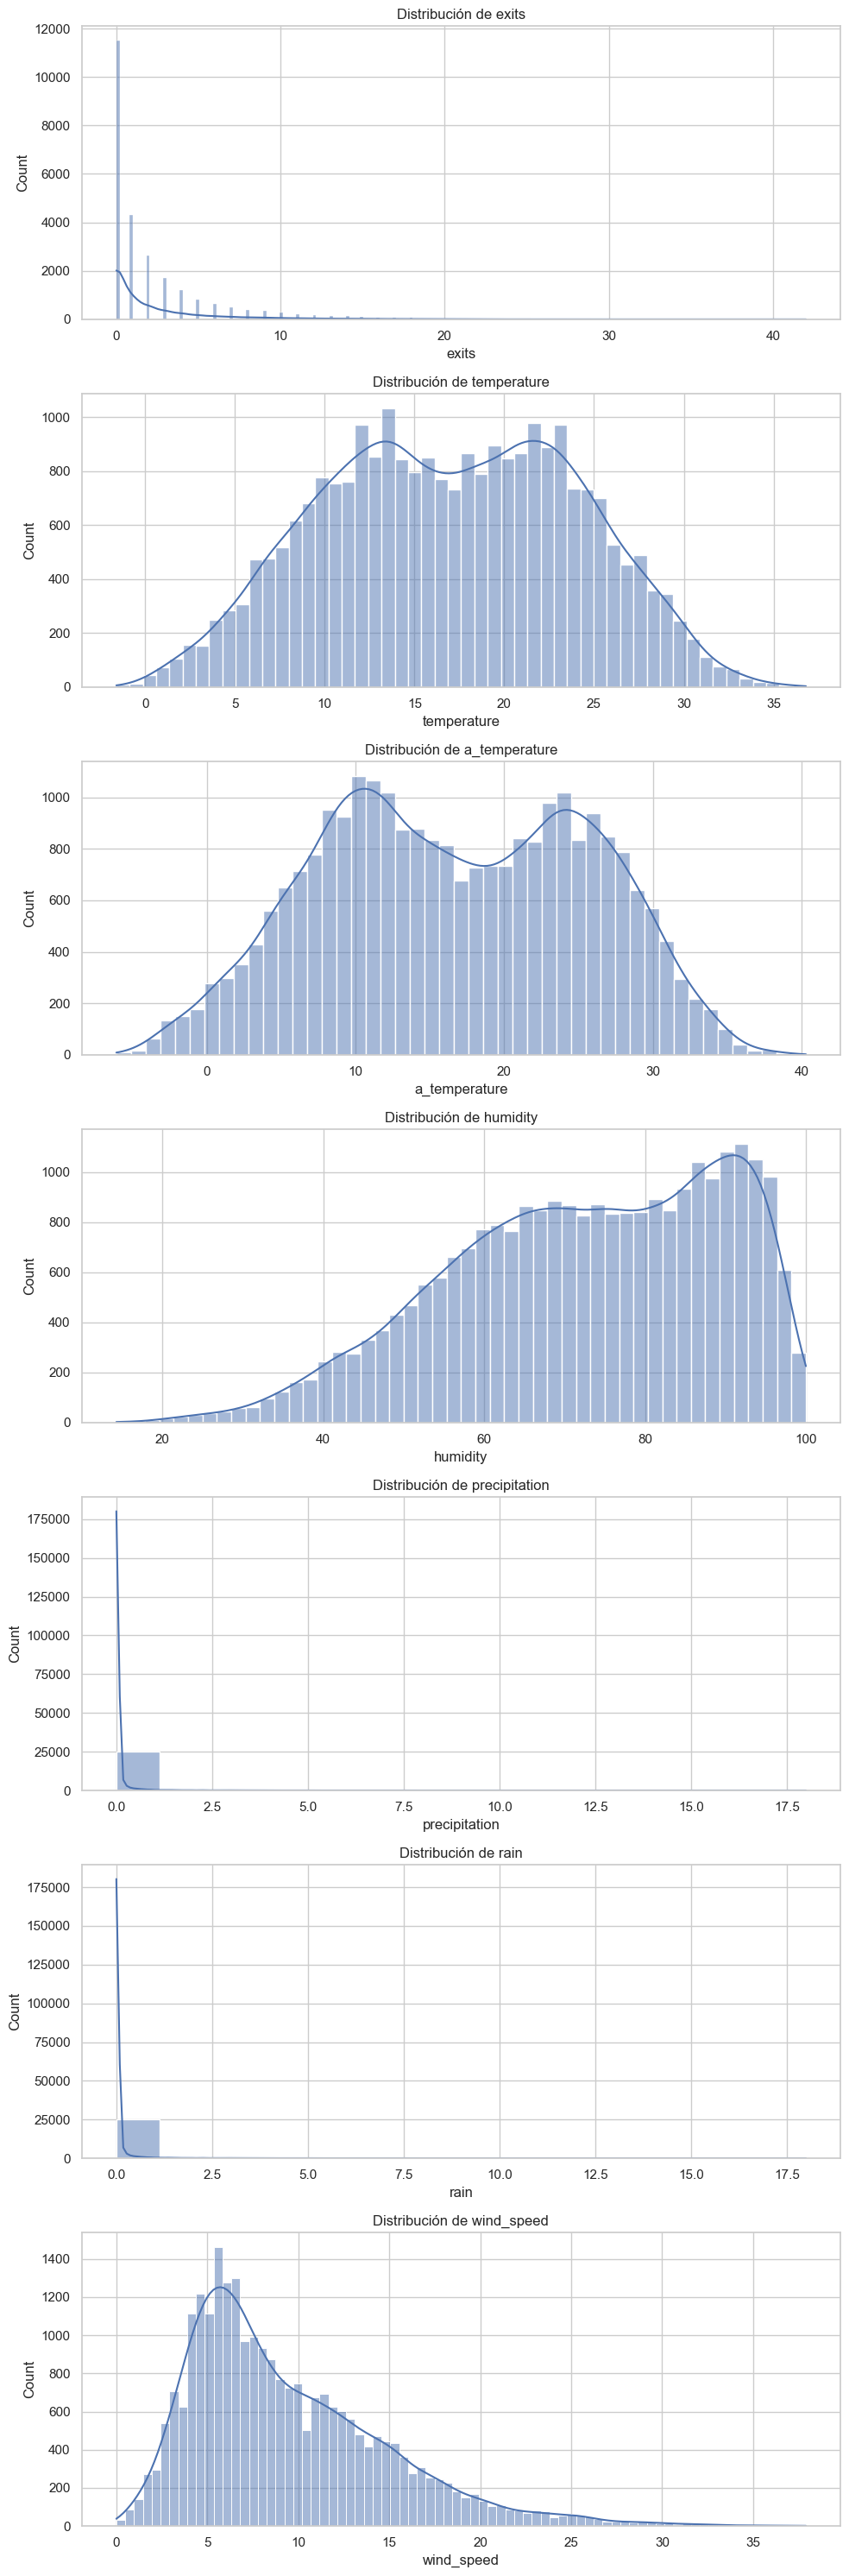

In [17]:
# Definir las variables numéricas y categóricas
num_vars = ['exits', 'temperature', 'a_temperature', 'humidity', 'precipitation', 'rain', 'wind_speed']
cat_vars = ['working_day', 'class_day', 'demand_satisfied']

# Crear histogramas para las variables numéricas
fig, axes = plt.subplots(len(num_vars), 1, figsize=(10, 30))
for i, var in enumerate(num_vars):
    sns.histplot(data[var], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribución de {var}')
plt.tight_layout()
hist_path = '/mnt/data/histograms.png'
plt.savefig(hist_path)
plt.close()

# Crear gráficos de barras para las variables categóricas
fig, axes = plt.subplots(len(cat_vars), 1, figsize=(10, 15))
for i, var in enumerate(cat_vars):
    sns.countplot(x=data[var], ax=axes[i])
    axes[i].set_title(f'Conteo de {var}')
plt.tight_layout()
bar_path = '/mnt/data/bar_charts.png'
plt.savefig(bar_path)
plt.close()

hist_path, bar_path